In [10]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
from sklearn.feature_extraction.text import TfidfVectorizer
## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
# ! pip install xlrd
# ! pip install openpyxl
## lda 
from gensim import corpora
import gensim
import plotnine
from plotnine import *
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## define constants and pathnames
GITHUB_DATA_PATH = "../data/"
DROPBOX_DATA_PATH = "../../../qss20_finalproj_rawdata/textasdata/"
MERGED_TEXT_JOBS_PKL = "../merged_addendums_jobdisclosures.pkl"
MERGED_TEXT_JOBS_CSV = "../merged_addendums_jobdisclosures.csv"


MERGED_TEXT_JOBS_PKL_DB = DROPBOX_DATA_PATH + "merged_addendums_jobdisclosures.pkl"

# Functions

In [11]:
## Text Processing
def processtext(row, colname, stopword_list,indicator, min_token_length = 4):
    
    ## get string form of listing
    string_of_col = str(row[colname]).lower()
    try:
        ## remove stopwords 
        remove_stop = [word for word in wordpunct_tokenize(string_of_col)
                      if word not in stopword_list]
        if indicator=="stem":
            processed_string = " ".join([porter.stem(i) 
                        for i in remove_stop if 
                        i.isalpha() and len(i) >= min_token_length])
        return(processed_string)
    except:
        processed_string = "" # to handle data errors where not actually text
        return(processed_string)


# Load merged data from previous script

In [44]:
LOAD_LOCAL = True
if LOAD_LOCAL:
    merged_data = pd.read_pickle("../merged_addendums_jobdisclosures.pkl")
else:
    merged_data = pd.read_pickle(MERGED_TEXT_JOBS_PKL_DB)
    
merged_data.shape

# # test csv; same num rows so should be fine to load as alternative if needed
# merged_data_csv = pd.read_csv(DROPBOX_DATA_PATH + MERGED_TEXT_JOBS_CSV)
# # merged_data_csv.shape

(13127, 143)

# Preprocess text

In [13]:
RUN_WITH_SAMPLE = True
if RUN_WITH_SAMPLE:
    merged_data = merged_data.sample(n = 500)


In [14]:
work_pattern = r"[a-zA-Z]*work[a-zA-Z]*"
all_listings = "".join(merged_data.JOB_DESCRIPTION)
all_tokens = word_tokenize(all_listings)

all_matches_work = [one_word for one_word in all_tokens if 
                   re.match(work_pattern, one_word)]

other_stopwords = ["after", "before", "employer", "employ", "job", "although", "provide", "complete","hour","time",
                  "begin","list","require","transportation"]+ all_matches_work

list_stopwords = stopwords.words("english")

stopwords_complete = list_stopwords + other_stopwords
    
porter = PorterStemmer()


In [15]:

merged_data['text_preprocess'] = merged_data.apply(processtext,
                             axis = 1,
                             args = ["JOB_DESCRIPTION", stopwords_complete,"stem"])
merged_data.head()


CASE_NUMBER                                     CASE_STATUS  \
6974  H-300-20010-245155            Determination Issued - Certification   
2263  H-300-20127-547322            Determination Issued - Certification   
8134  H-300-19355-212479            Determination Issued - Certification   
4114  H-300-20062-368171  Determination Issued - Certification (Expired)   
5641  H-300-20030-287827            Determination Issued - Certification   

                RECEIVED_DATE            DECISION_DATE  \
6974  2020-01-25 20:11:50.220  2020-03-19 00:00:00.000   
2263  2020-05-11 08:31:38.740  2020-06-11 00:00:00.000   
8134  2019-12-30 11:42:35.200  2020-01-30 00:00:00.000   
4114  2020-03-05 16:55:46.190  2020-03-25 00:00:00.000   
5641  2020-02-11 12:53:10.790  2020-03-04 00:00:00.000   

     TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR  \
6974          Individual Employer                    Y   
2263          Individual Employer                    Y   
8134          Individual Employer                    N   
4114          Individual Employer                    N   
5641          Individual Employer                    N   

     NATURE_OF_TEMPORARY_NEED EMERGENCY_FILING              EMPLOYER_NAME  \
6974                 Seasonal                N  Olivarez Honey Bees, Inc.   
2263                 Seasonal                N      Signet Builders, Inc.   
8134                 Seasonal                N      Briggs Brothers Farms   
4114                 Seasonal                N          Two P Farms, Inc.   
5641                 Seasonal                N    MORGIEWICZ PRODUCE INC    

     TRADE_NAME_DBA  ... PHONE_TO_APPLY              EMAIL_TO_APPLY  \
6974            NaN  ...    15308650298              Ali@ohbees.com   
2263            NaN  ...    15129947918    Labor@signetbuilders.com   
8134            NaN  ...    13088828026  briggsandsons@bwtelcom.net   
4114            NaN  ...    16623934241   petitions@h2acomplete.com   
5641            NaN  ...    18452584544          MORGPROD@YAHOO.COM   

              WEBSITE_TO_APPLY TOTAL_ADDENDUM_A_RECORDS HOURLY_SCHEDULE_BEGIN  \
6974                       NaN                      1.0                   NaN   
2263                       NaN                      0.0                   NaN   
8134                       NaN                      0.0                   NaN   
4114  https://www.mdes.ms.gov/                      4.0                   NaN   
5641                       NaN                      9.0                   NaN   

     HOURLY_SCHEDULE_END   TRLA  \
6974                 NaN  False   
2263                 NaN   True   
8134                 NaN  False   
4114                 NaN   True   
5641                 NaN  False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [49]:
## rj - above step takes awhile even on sample
## so writing; as a flag, this is with the sample

# merged_data.to_pickle(DROPBOX_DATA_PATH + "merged_addendums_preprocessed.pkl")

# Subset Merged_Data to TRLA and NonTRLA States

In [47]:
# TRLA
merged_TRLA=merged_data[merged_data.TRLA==True]
# NonTRLA
merged_nonTRLA=merged_data[merged_data.TRLA==False]

### Quick overview of number of job orders in that year range: all, TRLA, non-TRLA (post merging)


In [48]:
# case number all
merged_data.shape
# case number trla
merged_TRLA.shape
# case number trla
merged_nonTRLA.shape


(13127, 143)

(3684, 143)

(9443, 143)

# Raw term frequency (Tf-Idf)

In [9]:
vectorizer = TfidfVectorizer()
def tfidf_topwords(df,label):
    tf_idf = vectorizer.fit_transform(df['text_preprocess'])
    top_words = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
    stored=top_words.sum(axis=0).sort_values(ascending=False).head(10)
    plot=stored.plot.bar(title=label)
    plot.set_xlabel('Words')
    plot.set_ylabel('Tf-idf Score')
    fig = plot.get_figure()
    fig.savefig("../output/" + label+".png")

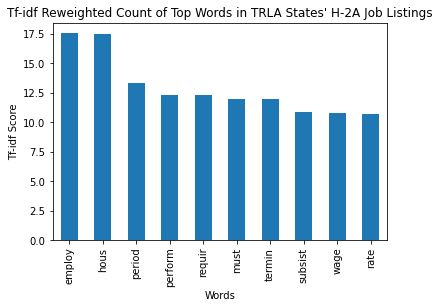

In [10]:
tfidf_topwords(merged_TRLA,"Tf-idf Reweighted Count of Top Words in TRLA States' H-2A Job Listings")

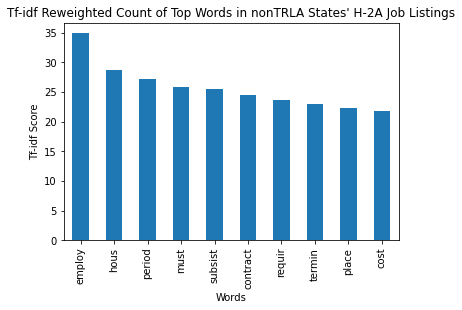

In [11]:
tfidf_topwords(merged_nonTRLA,"Tf-idf Reweighted Count of Top Words in nonTRLA States' H-2A Job Listings")

# Investigate the stemmed word "termin" in the original corpus

In [33]:
## works now :) 
pd.set_option('display.max_colwidth', None)
termin=merged_data.loc[merged_data.JOB_DESCRIPTION.str.contains("termin"),
               "JOB_DESCRIPTION"].drop_duplicates().head(5)

termin


6974                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

# LDA Topic Modeling

try to merge the topic model and plot into a single function.....

In [37]:
#function to create table suitable for plotting LDA modeling's result
def df_onetopic(one_listoftup, i):
    words = [one_tup[0] for one_tup in one_listoftup]
    weights = [one_tup[1] for one_tup in one_listoftup]
    words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
    words_weights_df['topic'] = "topic_" + str(i)
    return(words_weights_df)
topic_model(merged_TRLA)
topic_model(merged_nonTRLA)
topic_model(merged_data)



[[('employ', 0.018602643),
  ('period', 0.014361028),
  ('must', 0.011485276),
  ('requir', 0.011109751),
  ('hour', 0.01067425),
  ('hous', 0.0089287255),
  ('crop', 0.008897563),
  ('termin', 0.0087967925),
  ('perform', 0.008676587),
  ('condit', 0.008454961)],
 [('hous', 0.017458033),
  ('employ', 0.012223103),
  ('must', 0.011235374),
  ('provid', 0.010699022),
  ('termin', 0.010027167),
  ('requir', 0.009997492),
  ('period', 0.008548911),
  ('includ', 0.008083276),
  ('perform', 0.0071036518),
  ('properti', 0.0070986087)],
 [('employ', 0.012524259),
  ('perform', 0.012045734),
  ('hous', 0.01180098),
  ('requir', 0.01154569),
  ('rate', 0.011476938),
  ('wage', 0.01031449),
  ('supervisor', 0.00979424),
  ('assign', 0.008695178),
  ('premis', 0.008589007),
  ('termin', 0.008571511)]]

[[('hous', 0.016305253),
  ('must', 0.015056864),
  ('employ', 0.0114845885),
  ('requir', 0.010561329),
  ('provid', 0.009978707),
  ('harvest', 0.00912585),
  ('employe', 0.0089729205),
  ('rate', 0.008493205),
  ('perform', 0.007806552),
  ('period', 0.00760539)],
 [('employ', 0.016514832),
  ('termin', 0.014758033),
  ('period', 0.010642223),
  ('requir', 0.010567569),
  ('must', 0.010350358),
  ('perform', 0.010234923),
  ('hous', 0.010093557),
  ('provid', 0.008459013),
  ('employe', 0.007189422),
  ('includ', 0.0069879577)],
 [('employ', 0.024367547),
  ('requir', 0.018354943),
  ('period', 0.017251153),
  ('contract', 0.01628796),
  ('subsist', 0.016145777),
  ('cost', 0.014892396),
  ('place', 0.014695908),
  ('reimburs', 0.013134704),
  ('provid', 0.010059045),
  ('perform', 0.0094112735)]]

[[('must', 0.014456655),
  ('hous', 0.012679501),
  ('employ', 0.011832807),
  ('requir', 0.010589877),
  ('employe', 0.010370207),
  ('termin', 0.010001264),
  ('provid', 0.009694138),
  ('perform', 0.008686766),
  ('period', 0.00857385),
  ('rate', 0.0076639457)],
 [('employ', 0.0166077),
  ('hous', 0.015919507),
  ('requir', 0.015499378),
  ('must', 0.012028465),
  ('provid', 0.010851281),
  ('period', 0.010201728),
  ('perform', 0.009769108),
  ('hour', 0.0085086925),
  ('termin', 0.00831442),
  ('includ', 0.0077706627)],
 [('employ', 0.020887945),
  ('period', 0.0147080645),
  ('place', 0.011578371),
  ('requir', 0.010361883),
  ('termin', 0.009321436),
  ('perform', 0.009243416),
  ('rate', 0.008829669),
  ('subsist', 0.008743845),
  ('reimburs', 0.008279231),
  ('cost', 0.008022207)]]

In [34]:
## topic modeling (TRLA states)
def topic_model(df):
    df = df[df.text_preprocess != ""].copy()
    tokenized_text = [wordpunct_tokenize(one_text) for one_text in 
                                      df.text_preprocess]
    text_proc_dict = corpora.Dictionary(tokenized_text)
    text_proc_dict.filter_extremes(no_below = round(df.shape[0]*0.02),
                             no_above = round(df.shape[0]*0.98))
    corpus_fromdict_proc = [text_proc_dict.doc2bow(one_text) 
                   for one_text in tokenized_text]
    ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict_proc, 
                                         num_topics = 3, id2word=text_proc_dict, 
                                         passes=6, alpha = 'auto',
                                        per_word_topics = True)
    topics_fromshow2 = [ldamod.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]
    return(topics_fromshow2)
    

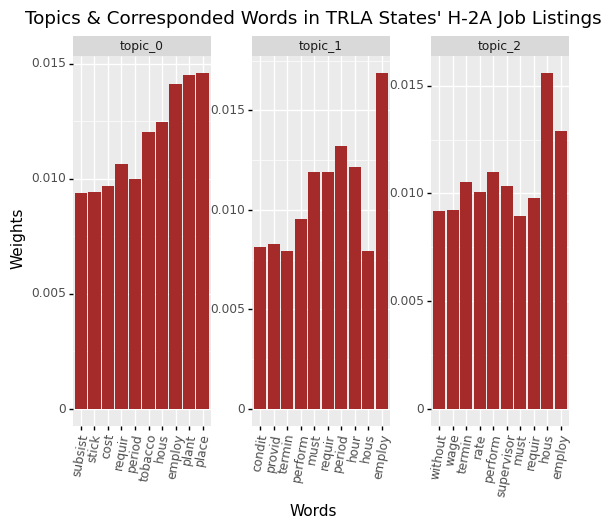

<ggplot: (8779879615657)>

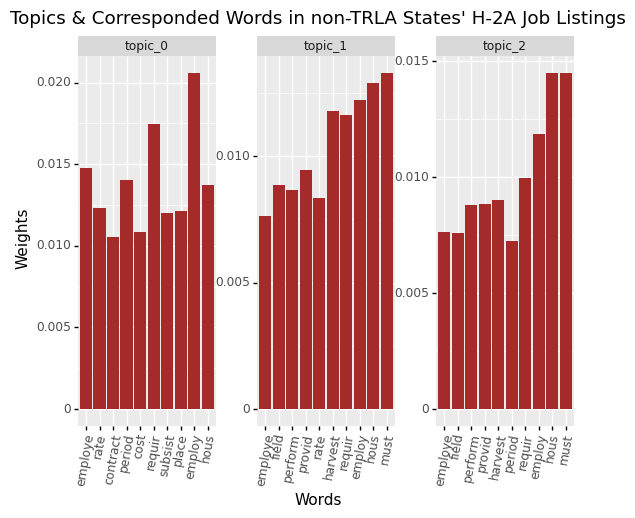

<ggplot: (8779814543354)>

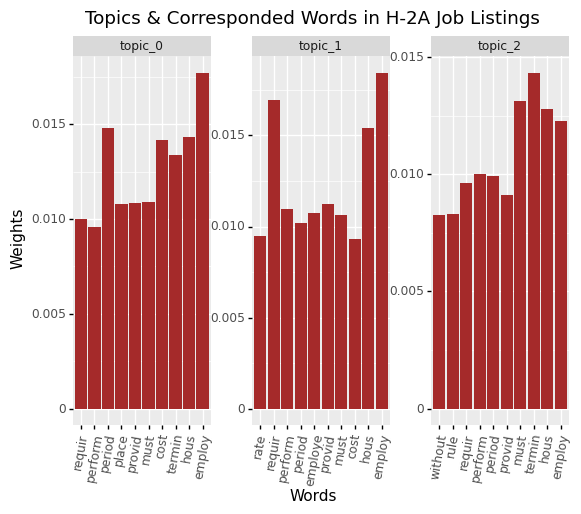

<ggplot: (8779814746585)>

In [39]:
#plot TRLA model
all_summary = []
for i in range(0, len(topic_model(merged_TRLA))):
    one_summary = df_onetopic(topic_model(merged_TRLA)[i], i)
    all_summary.append(one_summary)
all_summary_df = pd.concat(all_summary)
ggplot(all_summary_df) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights", title="Topics & Corresponded Words in TRLA States' H-2A Job Listings")

#plot nonTRLA model
all_summary = []
for i in range(0, len(topic_model(merged_nonTRLA))):
    one_summary = df_onetopic(topic_model(merged_nonTRLA)[i], i)
    all_summary.append(one_summary)
all_summary_df = pd.concat(all_summary)
ggplot(all_summary_df) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights", title="Topics & Corresponded Words in non-TRLA States' H-2A Job Listings")


#plot whole corpus model
all_summary = []
for i in range(0, len(topic_model(merged_data))):
    one_summary = df_onetopic(topic_model(merged_data)[i], i)
    all_summary.append(one_summary)
all_summary_df = pd.concat(all_summary)
ggplot(all_summary_df) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights",title= "Topics & Corresponded Words in H-2A Job Listings")
